In [6]:
# Imports
import os
import getpass

import numpy

import nipype
import nibabel
from nilearn.plotting import plot_roi
from nilearn import image
from nipype.interfaces.io import BIDSDataGrabber
from bids.layout import BIDSLayout
from nipype.pipeline import engine as pe

from matplotlib import pyplot as plt
from os.path import join
from bids.tests import get_test_data_path

In [9]:
user = getpass.getuser()

if user == 'ari':
    bids_ds_path = '/Volumes/SSD-Bercows/Joan/research/0_data/DS001_BIDS_andres/'

if user == 'andres':
    bids_ds_path = '/home/andres/Desktop/BIDS/DS001_BIDS_andres/'
    #deriv_dir = 

deriv_cmp_dir = join(bids_ds_path, "derivatives", "cmp")
deriv_nipype_dir = join(bids_ds_path, "nipype", "sub-01", "ses-01")

In [10]:
if user == 'ari':
    !tree -L 4 /Volumes/SSD-Bercows/Joan/research/0_data/Sample_Multi-Modal_BIDS_dataset/ds-sample/

if user == 'andres':
    !tree -L 4 /home/andres/Desktop/BIDS/Datos/ds-sample

/Volumes/SSD-Bercows/Joan/research/0_data/Sample_Multi-Modal_BIDS_dataset/ds-sample/
├── CHANGES
├── README
├── code
│   ├── license.txt
│   ├── ref_anatomical_config.ini
│   ├── ref_anatomical_config.json
│   ├── ref_diffusion_config.ini
│   ├── ref_diffusion_config.json
│   ├── ref_fMRI_config.ini
│   └── ref_fMRI_config.json
├── dataset_description.json
├── derivatives
│   ├── cmp
│   │   ├── dataset_description.json
│   │   └── sub-01
│   │       └── ses-01
│   ├── freesurfer
│   │   ├── dataset_description.json
│   │   ├── fsaverage
│   │   │   ├── label
│   │   │   ├── mri
│   │   │   ├── mri.2mm
│   │   │   ├── scripts
│   │   │   ├── surf
│   │   │   └── xhemi
│   │   └── sub-01_ses-01
│   │       ├── label
│   │       ├── mri
│   │       ├── scripts
│   │       ├── stats
│   │       ├── surf
│   │       ├── tmp
│   │       ├── touch
│   │       └── trash
│   └── nipype
│       ├── dataset_description.json
│       └── sub-01
│           └── ses-01
├── participants.tsv
└── sub-0

In [11]:
from nipype import Node, Function, Workflow
from nipype.interfaces.io import BIDSDataGrabber
bg = Node(BIDSDataGrabber(index_derivatives=True), name='bids-grabber')
bg.inputs.base_dir = bids_ds_path

bg.inputs.subject = '01'

bg.inputs.output_query = {'atlas': {'scope': 'Connectome Mapper',
                                  'suffix': 'atlas',
                                  'extensions': ['nii.gz']},
                         't1w': {'scope': 'Connectome Mapper',
                                  'suffix': 'T1w',
                                  'extensions': ['nii.gz']},
                         }

res = bg.run()

210305-16:47:57,156 nipype.workflow INFO:
	 [Node] Setting-up "bids-grabber" in "/private/var/folders/t7/t6fr54mx5cl1t4t9fcmq_rzr0000gq/T/tmpg56nky_h/bids-grabber".
210305-16:47:57,162 nipype.workflow INFO:
	 [Node] Running "bids-grabber" ("nipype.interfaces.io.BIDSDataGrabber")
210305-16:47:57,966 nipype.workflow INFO:
	 [Node] Finished "bids-grabber".


In [12]:
res.outputs


atlas = ['/Volumes/SSD-Bercows/Joan/research/0_data/DS001_BIDS_andres/derivatives/cmp/sub-01/anat/sub-01_label-L2008_desc-scale1_atlas.nii.gz', '/Volumes/SSD-Bercows/Joan/research/0_data/DS001_BIDS_andres/derivatives/cmp/sub-01/anat/sub-01_label-L2008_desc-scale2_atlas.nii.gz', '/Volumes/SSD-Bercows/Joan/research/0_data/DS001_BIDS_andres/derivatives/cmp/sub-01/anat/sub-01_label-L2008_desc-scale3_atlas.nii.gz', '/Volumes/SSD-Bercows/Joan/research/0_data/DS001_BIDS_andres/derivatives/cmp/sub-01/anat/sub-01_label-L2008_desc-scale4_atlas.nii.gz', '/Volumes/SSD-Bercows/Joan/research/0_data/DS001_BIDS_andres/derivatives/cmp/sub-01/anat/sub-01_label-L2008_desc-scale5_atlas.nii.gz', '/Volumes/SSD-Bercows/Joan/research/0_data/DS001_BIDS_andres/derivatives/cmp/sub-01/anat/sub-01_space-DWI_label-L2008_desc-scale1_atlas.nii.gz', '/Volumes/SSD-Bercows/Joan/research/0_data/DS001_BIDS_andres/derivatives/cmp/sub-01/anat/sub-01_space-DWI_label-L2008_desc-scale2_atlas.nii.gz', '/Volumes/SSD-Bercows/Joa

In [68]:
# Import Node and Function module
import nipype.interfaces.io as nio
from nipype.interfaces.utility import IdentityInterface

from nipype.interfaces.base import BaseInterfaceInputSpec, File, TraitedSpec, traits


class OverlayT1wAtlasInputSpec(BaseInterfaceInputSpec):
    #atlas_file = File(exists=True, mandatory=True, desc='atlas file') # Do not set exists=True !!
    #t1w_file = File(exists=True, mandatory=True, desc='t1w file')

    atlas_file = traits.List(exists=True, mandatory=True, desc='atlas file') # Do not set exists=True !!
    t1w_file = traits.List(exists=True, mandatory=True, desc='t1w file')

    
class OverlayT1wAtlasOutputSpec(TraitedSpec):
    fig_file = File(desc='png overlay')
    
    
from nipype.interfaces.base import BaseInterface

class OverlayT1wAtlas(BaseInterface):
    input_spec = OverlayT1wAtlasInputSpec
    output_spec = OverlayT1wAtlasOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        self.fig_file = self._overlay_t1w_parcellation(
            self.inputs.t1w_file,
            self.inputs.atlas_file
        )

        # And we are done
        return runtime
    
    def _overlay_t1w_parcellation(self, t1w_path, atlas_path):
        

        t1w_image = nibabel.load(t1w_path[0])

        parcellation = 'scale5'
                
        roi_path_selected = [elem for elem in atlas_path if parcellation in elem]
        roi_image = nibabel.load(roi_path_selected[0])

        output_file = bids_ds_path + '/Volumes//../../../nipype/sub-01/overlay.png'
        fig_file = plot_roi(roi_image, t1w_image, output_file = output_file)
        
        return output_file
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs['fig_file'] = self.fig_file
        return outputs


# Create a small example function
#def overlay_t1w_parcellation(subject, parcellation):
#    t1w_path = layout.get(datatype="anat", suffix="T1w", subject=subject, return_type="file", extension=["nii", "nii.gz"])
#    roi_path = layout.get(datatype="anat", scope="derivatives", suffix="atlas", subject=subject, return_type="file", extension="nii.gz")
#    
#    t1w_image = nibabel.load(t1w_path[0])
#    
#    roi_path_selected = [elem for elem in roi_path if parcellation in elem]
#    print(roi_path_selected)
#    roi_image = nibabel.load(roi_path_selected[0])
#    
#    fig = plot_roi(roi_image, t1w_image)
#    print(type(fig))
#    return fig

In [69]:
overlay = Node(OverlayT1wAtlas(), name='overlay_fig')

In [70]:
datasink = pe.Node(nio.DataSink(), name='sinker')
datasink.inputs.base_directory = deriv_nipype_dir
workflow = Workflow("overlay_workflow")
#workflow.connect(overlay, 'subject_id', datasink, 'container')

In [71]:
workflow.connect([(bg, overlay,
                   [('atlas', 'atlas_file'),
                    ('t1w','t1w_file')]
                  )])
workflow.connect(overlay, 'fig_file', datasink, 'fig_input')

210305-17:16:52,419 nipype.workflow INFO:
	 Workflow overlay_workflow settings: ['check', 'execution', 'logging', 'monitoring']
210305-17:16:52,433 nipype.workflow INFO:
	 Running serially.
210305-17:16:52,435 nipype.workflow INFO:
	 [Node] Setting-up "overlay_workflow.bids-grabber" in "/private/var/folders/t7/t6fr54mx5cl1t4t9fcmq_rzr0000gq/T/tmpg56nky_h/bids-grabber".
210305-17:16:52,441 nipype.workflow INFO:
	 [Node] Running "bids-grabber" ("nipype.interfaces.io.BIDSDataGrabber")
210305-17:16:53,33 nipype.workflow INFO:
	 [Node] Finished "overlay_workflow.bids-grabber".
210305-17:16:53,33 nipype.workflow INFO:
	 [Node] Setting-up "overlay_workflow.overlay_fig" in "/private/var/folders/t7/t6fr54mx5cl1t4t9fcmq_rzr0000gq/T/tmp_670_v4y/overlay_workflow/overlay_fig".
210305-17:16:53,40 nipype.workflow INFO:
	 [Node] Running "overlay_fig" ("__main__.OverlayT1wAtlas")
210305-17:16:54,956 nipype.workflow WARNING:
	 Storing result file without outputs
210305-17:16:54,957 nipype.workflow WARNI

RuntimeError: Workflow did not execute cleanly. Check log for details

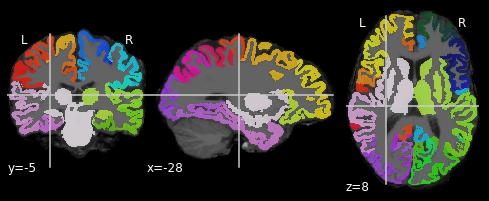

In [72]:
workflow.run()

In [ ]:
datasink